This is my solution for the skill test

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import os

os.sys.path.append('./..')
from utils.loadgenius import DataLoader
from utils.pretty import pprint, plot_missing_values, plot_value_counts
from utils.consignee_extract import parse_string_to_dict
from utils.country_name_detect import get_model

# Pointing the loader to the data loading instruction
dl = DataLoader('./../catalog.yml')

pprint(f"""Available dataset: \\
       {dl.list_datasets()}""")

Available dataset: \
       ['importer_normalized_data', 'main', 'ports']

In [2]:
%%time
# Loading in datasets
ports = dl.load('ports').drop('Unnamed: 0', axis=1)
main = dl.load('main').drop('Unnamed: 0', axis=1)
importer = dl.load('importer_normalized_data').drop('Unnamed: 0', axis=1)

CPU times: user 19.7 s, sys: 654 ms, total: 20.3 s
Wall time: 21.7 s


# Preprocess

# `importer_normalized_data.csv`: duplicated raw names

In [3]:
pprint("Some raw names are duplicated")
report = importer["importer_raw_name"].value_counts()
display(report[report > 1])

Some raw names are duplicated

MASONITE LAWRENCEVILLE DFS         2
ANATOLIA TILE & STONE, INC. 202    2
MASONITE LAWRENCEVILLE             2
SINTEX MINERALS                    2
METSO MINERALS WAUKESHA            2
Name: importer_raw_name, dtype: int64

Example:

In [4]:
importer.query('importer_raw_name=="MASONITE LAWRENCEVILLE DFS"')

,importer_rank,importer_raw_name,importer_deduped_name
21480,3354,MASONITE LAWRENCEVILLE DFS,MASONITE CORP
46134,9981,MASONITE LAWRENCEVILLE DFS,MASONITE LAWRENCEVILLE DFS


**Resolve:** Keep the row with highest rank 

In [5]:
importer = importer.sort_values('importer_rank').drop_duplicates(subset=['importer_raw_name'], keep='first')


## `ports.csv`: remove duplicates

In [6]:
print("ports: Rows before", ports.shape[0])
ports = (ports
         .drop_duplicates()
         .reset_index(drop=True)
        )
print("ports: Rows after de-duplicates", ports.shape[0])

ports: Rows before 10927
ports: Rows after de-duplicates 5726


## `main.csv`: extract important fields & drop duplicates

In [7]:
%%time
import multiprocessing as mp

original_columns = main.columns

with mp.Pool() as pool:
    result = pool.map(parse_string_to_dict, main['consignee'])
    
main['extracted'] = result
del(result)

CPU times: user 32.7 s, sys: 5.29 s, total: 38 s
Wall time: 41.3 s


In [8]:
# Double check if the extraction fails on any record
if any(main['extracted'].isna()):
    pprint("Extraction failed somewhere")
else:
    pprint("Extraction success")
    

Extraction success

Extract further on `cleaned_address_breakdown`

In [9]:
%%time
# Extract information in cleaned address
address_bits = ['address_number',
                 'country_name',
                 'place_name',
                 'state_name',
                 'street_name',
                 'street_name_post_type',
                 'street_name_pre_directional',
                 'street_name_pre_type',
                 'zip_code']

for bit in address_bits:
    main[bit] = main['extracted'].apply(lambda x: x['cleaned_address_breakdown'].get(bit, '')).replace('', pd.NA)
    print(f"Processing {bit}", end='\r')
    
main['id'] = main['extracted'].apply(lambda x: x['id'])
main['importer_raw_name'] = main['extracted'].apply(lambda x: x['name']).str.upper()

CPU times: user 17.7 s, sys: 72.9 ms, total: 17.8 s
Wall time: 18 s


Since we only care about names that exists in importer list:

In [15]:
importer['importer_raw_name'] = importer['importer_raw_name'].str.upper()
main = main.merge(importer, how='inner', on='importer_raw_name')

We want to check the number of nulls in each column:

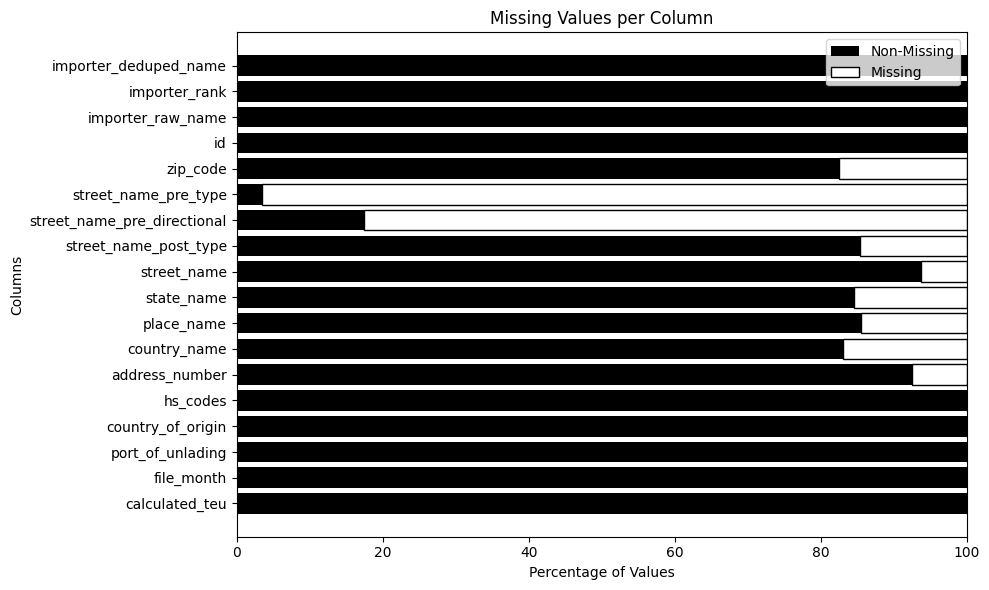

In [17]:
plot_missing_values(main.drop(["consignee", "extracted"],
                              axis=1),
                    as_percentage=True
                   )

### Observation 1: missing counts
`street_name_pre_type` and `street_name_pre_directional` have very high missing counts (approx 96% and 80% respectively)

### Observation 3: Imperfection in the cleaning method:

`cleaned_address_breakdown` seems to be a result by another extraction procedure.
This extraction is not perfect, as shown  in the graph of top 10 countries by frequencies in `main.csv`: sometimes it excludes STATES from UNITED STATES, yielding UNITED (which is a mistake)

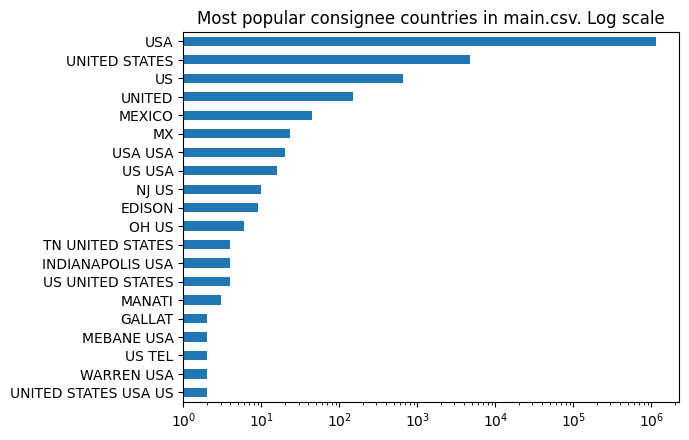

In [18]:
fig, ax = plt.subplots()
main['country_name'].value_counts().head(20)[::-1].plot.barh(log=True, ax=ax);
ax.set_title("Most popular consignee countries in main.csv. Log scale")
plt.show()

In [19]:
pprint("An example where UNITED STATES became UNITED after *cleaned*:")
pprint(main[main['country_name']=='UNITED']['consignee'].iloc[9])

An example where UNITED STATES became UNITED after *cleaned*:

{name=DAVID PEYSER SPORTSWEAR INC., address=90 SPENCE STREET, BAYSHORE, N.Y.11706, UNITED STATES., cleaned_address=90 SPENCE STREET, UNITED, cleaned_address_breakdown={address_number=90, country_name=UNITED, place_name=, state_name=, street_name=SPENCE, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=}, contact_name=, comm_number_qualifier=, comm_number=, id=9172da5f709b1914663d3b0e68f0243f}

In addition, sometimes the state name or another territory name gets in the `country_name`: NY in NY USA for instance.

Finally, synonyms were not handled at all: UNITED STATES, USA, US, USA US are the same thing.

Imperfection of the extraction on the country name level is a strong reason to assume the same happening in lower levels.

**How to fix that?** Use a better extraction method, such as Named Entity Recognition. For instance:

#### Demo Named-Entity-Recognition

In [20]:
from spacy import displacy
    
nlp = get_model() # Retrieve an example NER model for country name detection

# Get some example consignee strings
samples_others = list(main[main['country_name'].str.lower().str.contains('serbia|taiwan') == True]['consignee'])[:2]
samples_us = list(main[main['country_name'].str.lower().str.contains('usa|united state| us') == True]['consignee'])[:1]

pprint("Showing an alternative way to extract country name:")
for example in samples_others + samples_us:
    displacy.render(
        nlp(example),
        style='ent')
    print("="*20)

Showing an alternative way to extract country name:

In the example above, my model is able to detect both US and UNITED STATES as the synonyms for USA.

Since developing such as model requires gathering  more country names and synonyms, I only show an example for a small number of countries as above.

### Observation 2: duplicated rows

Many rows are exactly the same. **Possible reasons:**
- someone made a join with another duplicated dataframe ealier, resulting in duplicates in `main.csv`
- there's a missing column, which can be a key by itself or part of a composite key.

In [21]:
pd.set_option('display.max_colwidth', None)
pprint("Example of duplicated rows")
(
    main
    .query('id=="857a923157f99f7c13920a7e563ae9b2" & hs_codes=="HS CODE 8708 0000" & file_month==10')
    .sort_values('consignee')
    .head(3)[original_columns]
)

Example of duplicated rows

,consignee,calculated_teu,file_month,port_of_unlading,country_of_origin,hs_codes
1189926,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000
1199815,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000
1199816,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000


**Assuming this duplication is an error** (likely caused by join with duplicated data), I drop the duplicates:

In [22]:
before = main.shape[0]
pprint(f"`main.csv`: Number of rows before = {before}")
main = main.drop_duplicates(subset=original_columns)
pprint(f"`main.csv`: Number of rows after drop_duplicates = {main.shape[0]}")
pprint(f"Drop rate = {round(100*(1- main.shape[0]/before))}%")

`main.csv`: Number of rows before = 1385308

`main.csv`: Number of rows after drop_duplicates = 531578

Drop rate = 62%

### HS codes mapping

In this subsection, I convert the first 6 digits in HS codes to their description.

The first 6 digits tell the Subheadings of the product according to my [source](https://findrulesoforigin.org/en/glossary?uid=hs&returnto=faqscenter)

Implementation details:

- I used an opensource database [here](https://github.com/datasets/harmonized-system/tree/master) to lookup the hs codes
- To speed-up, I search for **unique hs codes** before mapping, rather than mapping straight away

In [24]:
hs_table = pd.read_csv('https://raw.githubusercontent.com/datasets/harmonized-system/master/data/harmonized-system.csv', dtype='str')

main['hs_codes_shorten'] = main['hs_codes'].str.replace(r'(\D)', '', regex=True).apply(lambda x: x[:6])

def query_hs_codes_desc(code, table):
    result = table.query("hscode==@code")['description']
    if result.shape[0] == 0:
        return None
    else:
        return list(result)[0]

hs_mapping = main[['hs_codes_shorten']].drop_duplicates().reset_index(drop=True)
hs_mapping['desc'] = hs_mapping['hs_codes_shorten'].apply(
    lambda x: query_hs_codes_desc(x, hs_table)
)

hs_mapping = hs_mapping.set_index('hs_codes_shorten')['desc']
hs_mapping = hs_mapping.to_dict()
main['hs_codes_desc'] = main['hs_codes_shorten'].apply(lambda x: hs_mapping[x])

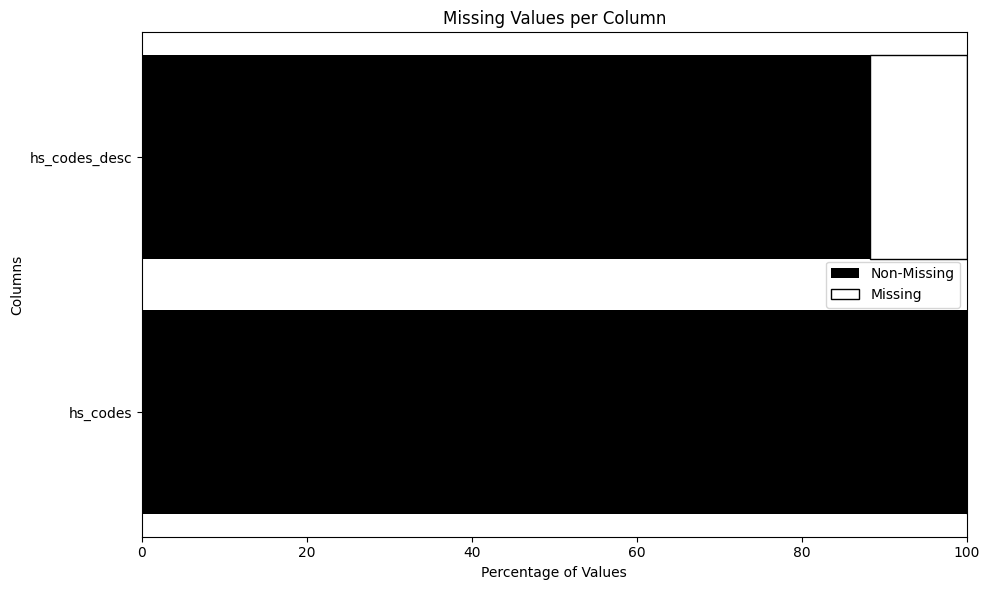

In [28]:
plot_missing_values(main[['hs_codes', "hs_codes_desc"]], as_percentage=True)

It shows that while every row has hs codes, about 11% don't have a know description according to my database (version 2022).

It is possible that some data uses 2021 versions: HS CODE 9401 3000 for instance.

Within the timeframe of this skill test, I simply ignore those data for now.

In [34]:
pprint("Showing some unknown hs codes:")
main[main['hs_codes_desc'].isna()][['hs_codes']].drop_duplicates().sort_values('hs_codes')

Showing some unknown hs codes:

,hs_codes
91471,HS CODE 0000 0000
872081,HS CODE 0000 0015
872082,HS CODE 0000 0018
547031,HS CODE 0000 0124
1176836,HS CODE 0000 0665
...,...
816787,HS CODE 9990 6300
165913,HS CODE 9990 7700
491994,HS CODE 9990 8700
344132,HS CODE 9990 8704


# Analytics plan

To find out which company is worth investing, we care about the following things:
- What they import
- How frequent they import that product
- How much (in teu) they import that product, compared to the norm
- How diverse are their imports: Diversing but small company might be a redflag. A focused portfolio is always a good sign.

In [108]:
importer_activity = (
    main[['id', 'hs_codes', 'file_month', 'calculated_teu']]
    .groupby(['id', 'hs_codes'])
    .agg(
        n_months=('file_month', 'nunique'), 
        sum_teu=('calculated_teu', 'sum')
    ).reset_index()
)

In [138]:
importer_activity['best_streak'] = importer_activity.groupby('id')['n_months'].transform('max')
importer_activity['worst_streak'] = importer_activity.groupby('id')['n_months'].transform('min')

Company activity: highest and lowest number of month per product

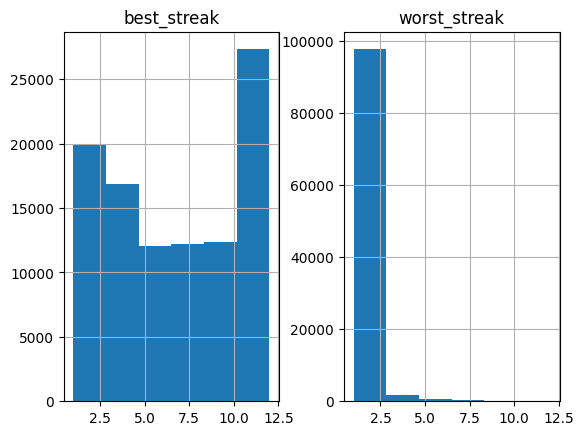

In [155]:
pprint("Company activity: highest and lowest number of month per product")
importer_activity[['best_streak', 'worst_streak']].hist(bins=6);

It shows that there is a big number of company that import the same hs codes monthly.

In [139]:
importer_diverse = importer_activity.groupby('id').agg(diverse_hs=('hs_codes', 'nunique')).reset_index()
importer_diverse = importer_diverse.merge(
    importer_activity[['id', 'best_streak', 'worst_streak']].drop_duplicates(subset='id'),
    on='id'
)

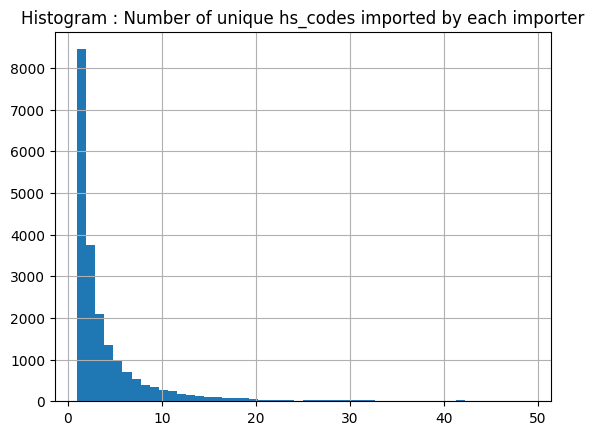

In [140]:
importer_diverse.query('diverse_hs < 50')['diverse_hs'].hist(bins=50)
plt.title("Histogram : Number of unique hs_codes imported by each importer");

It shows that normally a company imports no more than 10 HS codes. The majority import 5 of less.

We also want to see if the number of HS codes a company import may implies the level of sustainability:

<Axes: xlabel='diverse_hs', ylabel='worst_streak'>

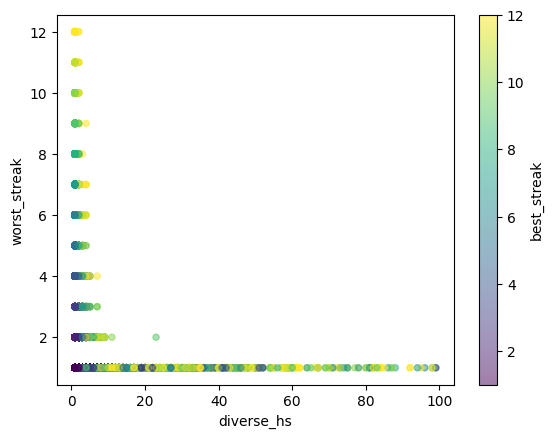

In [149]:
importer_diverse.query("diverse_hs <= 100").plot.scatter(x='diverse_hs',
                                                         c='best_streak',
                                                         y= 'worst_streak',
                                                         cmap='viridis',
                                                         alpha=.5)

If we focus on the area where worst_streak is > 6 months, it seems that the dots are also lighter (indicating higher values of best_streak), and that the values of diverse_hs is also low.

In case that Blume wanted to be very safe, worst_streak can be an important indicator. 

We definitely do not want to pay attention to company with low best_streak: It is highly unlikely that you import less than 4 month for something profitable.

Also, we may want to think of this problem as predicting on company--product pair

# EDA

Sincek

In [97]:

import numpy as np

In [101]:
main.groupby('hs_codes')['calculated_teu'].apply(np.median).sort_values(ascending=False)

hs_codes
HS CODE 3506 1087    116.0
HS CODE 8507 2083    116.0
HS CODE 8609 0030    100.0
HS CODE 3929 6000     96.0
HS CODE 8407 3482     92.0
                     ...  
HS CODE 8130 0000      0.0
HS CODE 8482 1030      0.0
HS CODE 5801 0000      0.0
HS CODE 1159 0800      0.0
HS CODE 7216 3010      0.0
Name: calculated_teu, Length: 19157, dtype: float64

In [96]:
main.head(10)

,consignee,calculated_teu,file_month,port_of_unlading,country_of_origin,hs_codes,extracted,address_number,country_name,place_name,...,street_name_post_type,street_name_pre_directional,street_name_pre_type,zip_code,id,importer_raw_name,importer_rank,importer_deduped_name,hs_codes_shorten,hs_codes_desc
0,"{name=BSN MEDICAL GMBH, address=400 OLMOS BLVD STE A HIDALGO TX 78557 US, cleaned_address=400 OLMOS BLVD, HIDALGO, TX 78557, USA, cleaned_address_breakdown={address_number=400, country_name=USA, place_name=HIDALGO, state_name=TX, street_name=OLMOS, street_name_post_type=BLVD, street_name_pre_directional=, street_name_pre_type=, zip_code=78557}, contact_name=, comm_number_qualifier=, comm_number=, id=54d5cf3a5f2e4467ec69ab0ddc6c80db}",0.035356,1,5301,GERMANY,HS CODE 5806 2000,"{'name': 'BSN MEDICAL GMBH', 'cleaned_address_breakdown': {'address_number': '400', 'country_name': 'USA', 'place_name': 'HIDALGO', 'state_name': 'TX', 'street_name': 'OLMOS', 'street_name_post_type': 'BLVD', 'street_name_pre_directional': '', 'street_name_pre_type': '', 'zip_code': '78557'}, 'id': '54d5cf3a5f2e4467ec69ab0ddc6c80db'}",400,USA,HIDALGO,...,BLVD,<NA>,<NA>,78557,54d5cf3a5f2e4467ec69ab0ddc6c80db,BSN MEDICAL GMBH,8267,BSN MEDICAL GMBH,580620,"Fabrics; narrow (excluding pile fabrics), containing by weight 5% or more of elastomeric yarn or rubber thread"
1,"{name=BSN MEDICAL GMBH, address=400 OLMOS BLVD. STE A 78557 HIDALGO USA, cleaned_address=400 OLMOS BLVD, HIDALGO, USA, cleaned_address_breakdown={address_number=400, country_name=, place_name=HIDALGO, state_name=USA, street_name=OLMOS, street_name_post_type=BLVD, street_name_pre_directional=, street_name_pre_type=, zip_code=}, contact_name=, comm_number_qualifier=, comm_number=, id=54d5cf3a5f2e4467ec69ab0ddc6c80db}",2.000000,6,5301,IRELAND,HS CODE 7019 1910,"{'name': 'BSN MEDICAL GMBH', 'cleaned_address_breakdown': {'address_number': '400', 'country_name': '', 'place_name': 'HIDALGO', 'state_name': 'USA', 'street_name': 'OLMOS', 'street_name_post_type': 'BLVD', 'street_name_pre_directional': '', 'street_name_pre_type': '', 'zip_code': ''}, 'id': '54d5cf3a5f2e4467ec69ab0ddc6c80db'}",400,<NA>,HIDALGO,...,BLVD,<NA>,<NA>,<NA>,54d5cf3a5f2e4467ec69ab0ddc6c80db,BSN MEDICAL GMBH,8267,BSN MEDICAL GMBH,701919,"Glass fibres; (including glass wool), threads and mats, other than mechanically or chemically bonded mats"
2,"{name=BSN MEDICAL GMBH, address=400 OLMOS BLVD STE A HIDALGO TX 78557 US, cleaned_address=400 OLMOS BLVD, HIDALGO, TX 78557, USA, cleaned_address_breakdown={address_number=400, country_name=USA, place_name=HIDALGO, state_name=TX, street_name=OLMOS, street_name_post_type=BLVD, street_name_pre_directional=, street_name_pre_type=, zip_code=78557}, contact_name=, comm_number_qualifier=, comm_number=, id=54d5cf3a5f2e4467ec69ab0ddc6c80db}",0.104846,8,5301,GERMANY,HS CODE 5806 0000,"{'name': 'BSN MEDICAL GMBH', 'cleaned_address_breakdown': {'address_number': '400', 'country_name': 'USA', 'place_name': 'HIDALGO', 'state_name': 'TX', 'street_name': 'OLMOS', 'street_name_post_type': 'BLVD', 'street_name_pre_directional': '', 'street_name_pre_type': '', 'zip_code': '78557'}, 'id': '54d5cf3a5f2e4467ec69ab0ddc6c80db'}",400,USA,HIDALGO,...,BLVD,<NA>,<NA>,78557,54d5cf3a5f2e4467ec69ab0ddc6c80db,BSN MEDICAL GMBH,8267,BSN MEDICAL GMBH,580600,None
3,"{name=BSN MEDICAL GMBH, address=PO BOX 580 HIDALGO TX 78557 US, cleaned_address=, HIDALGO, TX 78557, USA, cleaned_address_breakdown={address_number=, country_name=USA, place_name=HIDALGO, state_name=TX, street_name=, street_name_post_type=, street_name_pre_directional=, street_name_pre_type=, zip_code=78557}, contact_name=, comm_number_qualifier=, comm_number=, id=54d5cf3a5f2e4467ec69ab0ddc6c80db}",1.000000,12,5301,SRI LANKA,HS CODE 5604 1000,"{'name': 'BSN MEDICAL GMBH', 'cleaned_address_breakdown': {'address_number': '', 'country_name': 'USA', 'place_name': 'HIDALGO', 'state_name': 'TX', 'street_name': '', 'street_name_post_type': '', 'street_name_pre_direction